# Project Overview

In this project we will perform exploratory data analysis to provide feedback to a stakeholder.
Data visualization will be used as a tool to deliver our recommendation.

# Business Problem

Microsoft is considering to expand its business into creating video content for entertainment industry. They need guidance for creating these contents.  The objective of this project is to provide Microsoft data driven feedback for creating successful content with optimum return on investment.

## Master Data Set
The master data set is split into two. The first is used for analysis of ROI in different genre and movie rating indicator. This consists of the following available databases:
* MovieBasics from IMDB database
* MovieRatings from IMDB database
* The Numbers database
* The Movie database

The second is used for analysis of ROI to movie people and this consists of:
* The Numbers database
* Directors from IMDB database
* Writers from IMDB database
* Known_for from IMDB database

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import scipy.stats as stats
import sqlite3
from matplotlib.colors import ListedColormap
from import_and_clean_data import generatePeopleDF

%matplotlib inline

## Reading data files and merge data

The database files are read into Pandas dataframes. The dataframes are merged into in single
dataframe.

In [2]:
# Read relevant tables into pandas dataframe
# IMDB database
# ***IMPORTANT*** Make sure to unzip the "im.db.zip" file into "im.db"
con = sqlite3.connect('../data/im.db') 
cursor = con.cursor()
imdb_schema_df = pd.read_sql('''
SELECT 
    *
FROM
    sqlite_master
''', con)

In [3]:
movie_basics_df = pd.read_sql('''
SELECT 
    *
FROM
    movie_basics
''', con)

In [4]:
movie_ratings_df = pd.read_sql('''
SELECT 
    *
FROM
    movie_ratings
''', con)

In [5]:
# The Numbers movie information table
tn_movies_df = pd.read_csv('../data/tn.movie_budgets.csv.gz')

In [6]:
# TheMovieDB movie information table
tmdb_movies_df = pd.read_csv('../data/tmdb.movies.csv.gz')

In [7]:
# # Merge the following pandas dataframes together
#   1. movie_basics_df (from IMDB database)
#   2. movie_ratings_df (from IMDB database)
#   3. tn_movies_df (from The Numbers database)
#   4. tmdb_movies_df (from The Movie database)

movie_basics_ratings_df = pd.read_sql('''
SELECT
    *
FROM 
    movie_basics
    LEFT JOIN movie_ratings
        ON movie_basics.movie_id = movie_ratings.movie_id
''', con)

In [8]:
movie_basics_ratings_tmdb_df = movie_basics_ratings_df.merge(tmdb_movies_df,
                                                             left_on='primary_title',
                                                             right_on='title',
                                                             how='inner')

In [9]:
movie_basics_ratings_tmdb_tn_df = movie_basics_ratings_tmdb_df.merge(tn_movies_df,
                                                                     left_on='title',
                                                                     right_on='movie',
                                                                     how='inner')

In [10]:
# Generate DataFrame for movie people  
people_df = generatePeopleDF('../data/tn.movie_budgets.csv.gz', '../data/im.db')

C:\Users\nicho\.conda\envs\learn-env\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


## Data cleaning & engineering
Columns not needed for analysis are drooped. Convert 'production_budget', 'domestic_gross', 'worldwide_gross' to integer and 'release_date' to datetime object. Create a new column called 'Assigned_genre_ids' and assign to it the first number of 'genre_ids' and covert this to integer. Drop rows where 'genre_ids' cell is empty and drop rows if production_budget, domestic_gross or worldwide_gross has a value of zero. Remove rows with release date less than 2000. Drop duplicated rows. Create a dictionary called 'genre_ids_dict' with key assocaited with 'Assigned_genre_ids' and values with writtten genre name. Then, create a column called 'Assigned_genre_name' and use the dictionary to input written genre name with the respective key. Then combine low number genre to one that is most similar. Two additional columns are created for 'Pofit' and 'ROI' calculation. Create a dataframe called 'genre_ratings_df' by copying 'movie_basics_ratings_tmdb_tn_df' and rearrange columns so related columns placed close to one another.

In [11]:
# Remove columns not needed for analysis
# for column in movie_basics_ratings_tmdb_tn_df.colum
columns_to_drop = ['movie_id','primary_title', 'original_title_x', 'start_year',
       'runtime_minutes', 'movie_id','Unnamed: 0', 'id_x', 'original_language',
        'original_title_y','vote_average','title','id_y','release_date_y']

movie_basics_ratings_tmdb_tn_df.drop(columns = columns_to_drop,inplace=True)

In [12]:
# set movie column as dataframe index
movie_basics_ratings_tmdb_tn_df.set_index('movie',inplace=True)

In [13]:
# Remove any non-digit character from columns production_budget, domestic_gross
# and worldwide_gross and then convert the value for these columns to integer
for column_title in ['production_budget','domestic_gross','worldwide_gross']:
    movie_basics_ratings_tmdb_tn_df[column_title].replace('[^\d]','',inplace=True,regex=True)
    movie_basics_ratings_tmdb_tn_df[column_title] = movie_basics_ratings_tmdb_tn_df[
        column_title].astype(np.int64)

In [14]:
#Change 'release_date_x' to datetime object and change column name to 'release_date'
movie_basics_ratings_tmdb_tn_df['release_date_x'] = pd.to_datetime(
    movie_basics_ratings_tmdb_tn_df['release_date_x'])

movie_basics_ratings_tmdb_tn_df.rename(columns ={'release_date_x' : 'release_date'},
                                      inplace=True)

In [15]:
#Replace from 'genre_ids' column the brackets '[' and ']' surrounding the numbers
movie_basics_ratings_tmdb_tn_df['genre_ids'].replace('[\[\]]','',regex=True,inplace=True)


In [16]:
# Create a new column called 'Assigned_genre_ids' and assign to it the first number 
# from 'genre_ids
movie_basics_ratings_tmdb_tn_df['Assigned_genre_ids'] = movie_basics_ratings_tmdb_tn_df[
    'genre_ids'].map(lambda s: s.split(',')[0])


In [17]:
# Drop rows where 'genre_ids' cell is empty
movie_basics_ratings_tmdb_tn_df.drop(
    movie_basics_ratings_tmdb_tn_df[
        movie_basics_ratings_tmdb_tn_df['genre_ids']== ''].index,inplace=True)

#drop rows if production_budget, domestic_gross or worldwide_gross has a value of zero
movie_basics_ratings_tmdb_tn_df.drop(movie_basics_ratings_tmdb_tn_df[
    (movie_basics_ratings_tmdb_tn_df['production_budget'] == 0) |
                 (movie_basics_ratings_tmdb_tn_df['domestic_gross'] == 0) | 
                 (movie_basics_ratings_tmdb_tn_df[
                     'production_budget'] == 0)].index,inplace=True)

#Remove rows with release date less than 2000
movie_basics_ratings_tmdb_tn_df.drop(movie_basics_ratings_tmdb_tn_df[
    movie_basics_ratings_tmdb_tn_df[
        'release_date'] < pd.to_datetime('2000')].index,inplace=True)

# Change data type for column 'Assigned_genre_ids' to integer
movie_basics_ratings_tmdb_tn_df['Assigned_genre_ids'] = movie_basics_ratings_tmdb_tn_df[
    'Assigned_genre_ids'].astype(int)


In [18]:
# Drop duplicated rows
movie_basics_ratings_tmdb_tn_df.drop_duplicates(inplace=True)


In [19]:
# Create a dictionary called 'genre_ids_dict' with key assocaited with 'Assigned_genre_ids'
# and values with writtten genre name  
genre_ids_dict = {
                28 : 'Action', 12 : 'Adventure', 16 : 'Animation', 35 : 'Comedy',
                80 : 'Crime', 99 : 'Documentary', 18: 'Drama', 10751 : 'Family',
                14 : 'Fantasy', 36 : 'History', 27 : 'Horror', 10402 : 'Music',
                9648 : 'Mystery', 10749 : 'Romance', 878 : 'Science Fiction',
                10770 : 'TV Movie', 53 : 'Thriller', 10752 : 'War', 37 : 'Western'}

# Create a column called 'Assigned_genre_name' and use the dictionary called 'genre_ids_dict
# input written genre name with the respective key
movie_basics_ratings_tmdb_tn_df['Assigned_genre_name'] = movie_basics_ratings_tmdb_tn_df[
    'Assigned_genre_ids'].map(lambda n: genre_ids_dict[n])


In [20]:
#creating 'Profit' column
movie_basics_ratings_tmdb_tn_df['Profit'] = movie_basics_ratings_tmdb_tn_df[
    'worldwide_gross'] - movie_basics_ratings_tmdb_tn_df['production_budget'] 

#creating 'ROI' column
movie_basics_ratings_tmdb_tn_df['ROI'] = (movie_basics_ratings_tmdb_tn_df[
    'Profit']) / (movie_basics_ratings_tmdb_tn_df['production_budget'])*100

In [21]:
# Create a dataframe called 'genre_ratings_df' by copying 'movie_basics_ratings_tmdb_tn_df' 
# and rearrange columns so related columns placed close to one another

genre_ratings_df = movie_basics_ratings_tmdb_tn_df[['genres','genre_ids','Assigned_genre_ids',
                                                   'Assigned_genre_name','averagerating',
                                                    'numvotes','popularity','vote_count',
                                                    'release_date','production_budget',
                                                    'domestic_gross','worldwide_gross',
                                                   'Profit','ROI']].copy()


In [22]:
genre_ratings_df['Assigned_genre_name'].value_counts()

Drama              843
Comedy             421
Action             378
Thriller           214
Horror             212
Adventure          146
Documentary        140
Crime              133
Romance            103
Science Fiction     77
Animation           76
Mystery             56
Fantasy             52
Family              29
History             24
War                 18
Western             10
Music                7
TV Movie             1
Name: Assigned_genre_name, dtype: int64

In [23]:
# Combine similar genres into one
genre_mapping = {
    'Action': 'ActAdv',
    'Adventure': 'ActAdv',
    'War':'ActAdv',
    'Western':'ActAdv',
    'Drama' : 'Drama',
    'Thriller': 'Thriller',
    'Mystery': 'Thriller',
    'Horror': 'Horror',
    'Crime' : 'Crime',
    'Comedy' : 'Comedy',
    'Romance': 'Romance',
    'Documentary': 'Documentary',
    'History': 'Documentary',
    'Science Fiction': 'SciFan',
    'Fantasy': 'SciFan',
    'Family': 'Family',
    'Animation': 'Family',
    'Music': 'Family'    
}

genre_ratings_df['Assigned_genre_name'] = genre_ratings_df[
    'Assigned_genre_name'].map(genre_mapping) 
genre_ratings_df['Assigned_genre_name'].value_counts()

Drama          843
ActAdv         552
Comedy         421
Thriller       270
Horror         212
Documentary    164
Crime          133
SciFan         129
Family         112
Romance        103
Name: Assigned_genre_name, dtype: int64

## Data visualization

### The case for targeting world-wide market in order to maximize profit potential

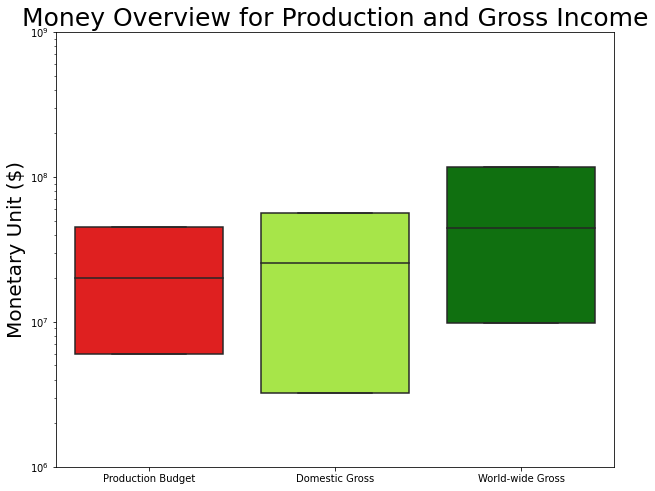

In [24]:
# Create a new dataframe called 'budget_domestic_worldwide_df' from 'genre_ratings_df'
# that has three colulmns for production_budget, domestic_gross and worldwide_gross
budget_domestic_worldwide_df = genre_ratings_df[['production_budget','domestic_gross',
                                                 'worldwide_gross']].copy()


# Make boxplot for production_budget, domestic_gross and worldwide_gross all in one axes
# Remove whiskers and outliers for better visualization
fig = plt.subplots(figsize=(10,8))
colors = ['#FF0000','#ADFF2F','#008000']
money_overview =sns.boxplot(x='variable',y='value',
                            data=pd.melt(budget_domestic_worldwide_df),
                            whis=0,fliersize=0,palette=colors)

money_overview.set_title('Money Overview for Production and Gross Income',fontsize=25)
money_overview.set_xlabel('')
money_overview.set_xticklabels(['Production Budget','Domestic Gross','World-wide Gross'])
money_overview.set_ylabel('Monetary Unit ($)',fontsize=20)
money_overview.set_yscale('log')
money_overview.set_ylim(10**6,10**9);
plt.savefig('production_gross.jpeg')

### Make the case for Genre vs return on investment (ROI)

In [25]:
# Create data frame for genre ratings
genre_roi_df = genre_ratings_df[['Assigned_genre_name', 'ROI', 'Profit','production_budget',
                                'domestic_gross','worldwide_gross','release_date']].copy()

# Make a color dictionary to match genre color between plots
colors_dict = {
    'Drama':'grey',          
    'ActAdv':'grey',         
    'Comedy': 'grey',         
    'Thriller':'violet',       
    'Horror': 'Green',         
    'Documentary': 'grey',    
    'Crime': 'grey',          
    'SciFan': 'Orange',         
    'Family': 'Red',          
    'Romance': 'blue'         

}


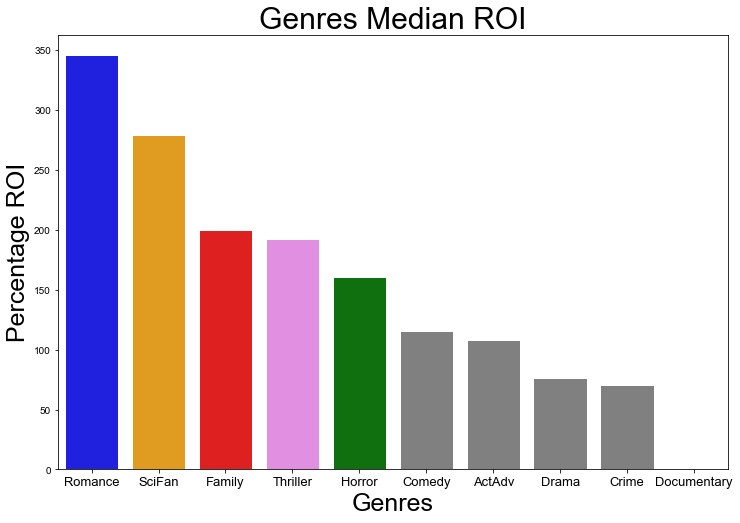

In [26]:
# Create a dataframe for to used for ROI-Genre bar plot
grouped_genre_roi_df = genre_roi_df.groupby('Assigned_genre_name').agg(
    {'ROI' : 'median'}).sort_values(by='ROI',ascending=False)

colors = [colors_dict[name] for name in grouped_genre_roi_df.index]

fig,ax = plt.subplots(figsize=(12,8))
sns.set_theme(style='white')
genre_roi_plot = sns.barplot(x=grouped_genre_roi_df.index,y='ROI',data=grouped_genre_roi_df,
                            palette=colors)
genre_roi_plot.set_title('Genres Median ROI',fontsize=30)
genre_roi_plot.set_xlabel('Genres',fontsize=25)
genre_roi_plot.set_xticklabels(grouped_genre_roi_df.index,size=13)
genre_roi_plot.set_ylabel('Percentage ROI',fontsize=25)

plt.savefig('genre_roi.jpeg')


## Evaluate TMDB ratings relative to Genre

In [27]:
# Create a new data frame called 'ratings_df'
ratings_df = genre_ratings_df[['Assigned_genre_name','averagerating','numvotes',
                              'popularity','vote_count','worldwide_gross']].copy()

In [28]:
popularity_df = ratings_df.groupby('Assigned_genre_name').agg(
    {'popularity' : 'median'}).sort_values(by='popularity',ascending=False)[:10]


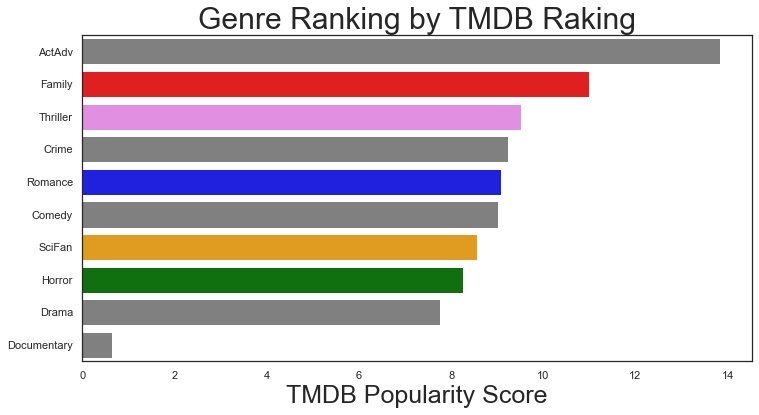

In [29]:
# Make two horizontal bar plots showing top ten based on the two ratings

fig,ax = plt.subplots(figsize=(12,6))
colors = [colors_dict[name] for name in popularity_df.index]
popularity_plot = sns.barplot(data=popularity_df, x = 'popularity',
                                             y = popularity_df.index, 
                                             orient= 'h',palette=colors)

popularity_plot.set_title('Genre Ranking by TMDB Raking',fontsize=30)
popularity_plot.set_ylabel('')
popularity_plot.set_xlabel('TMDB Popularity Score',fontsize=25);
plt.savefig('genre_rating.jpeg')


### Observing differences between groups of people

As can be seen, the distribution of the coefficient of variation of box office revenue per person (more simply, risk) is virtually the same across directors, writers, and actors.


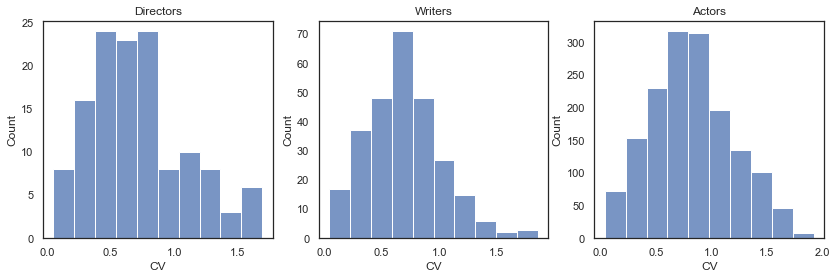

In [30]:
# How about we all use Seaborn to stay consistant with throught this notebook?
fig, ax = plt.subplots(ncols=3, figsize=(14,4))

bins = 10

directors = sns.histplot(people_df.loc['directors'].coefficient_of_variation,bins=bins,ax=ax[0])
directors.set_title('Directors')
directors.set_xlabel('CV')
directors.set_ylabel('Count')

writers = sns.histplot(people_df.loc['writers'].coefficient_of_variation, bins=bins,ax=ax[1])
writers.set_title('Writers')
writers.set_xlabel('CV')
writers.set_ylabel('Count')

actors = sns.histplot(people_df.loc['actors'].coefficient_of_variation, bins=bins,ax=ax[2])
actors.set_title('Actors')
actors.set_xlabel('CV')
actors.set_ylabel('Count');

In [31]:
# Modularized code into a function
# Generates a specific DataFrame based on parameters
def generateSpecDF(df, target_group, target_genre): # target_genre can be a string or a list
    # Eliminates people who are not relevant to the target genre
    spec_df = df.loc[target_group].copy()
    for row in df.loc[target_group].index:
        is_missing_genre = True
        for genre in df.loc[target_group].iloc[row].genres:
            if genre in target_genre:
                is_missing_genre = False
                break
        if(is_missing_genre):
            spec_df = spec_df.drop(row)
    spec_df = spec_df.reset_index().drop(columns=['index'])
    
    # Generates the scatter plot
    fig, ax = plt.subplots(figsize=(10,8))
    
    sns.scatterplot(x=spec_df.std_total_gross,
                    y=spec_df.mean_total_gross,
                    c=spec_df.mean_total_gross - spec_df.std_total_gross,
                    cmap='cool',
                    marker='o',
                    s=50)
    
    # Miscellaneous formatting
    ax.set_xlim(left=0)
    ax.set_ylim(bottom=2.5)
    ax.set_xticks(np.linspace(int(round(max(spec_df.mean_total_gross), -8) / 5), int(round(max(spec_df.mean_total_gross), -8)), num=5))
    ax.ticklabel_format(style='plain')
    tick = mtick.StrMethodFormatter('${x:,.0f}')
    ax.xaxis.set_major_formatter(tick)
    ax.yaxis.set_major_formatter(tick)
    
    # Labels (accounts for list or string input)
    if(type(target_genre) == str):
        ax.set_title('Best-Performing ' + target_group.title() + ' in ' + target_genre.title() + ' Movies')
    elif(len(target_genre) == 1):
        ax.set_title('Best-Performing ' + target_group.title() + ' in ' + target_genre[0].title() + ' Movies')
    elif(len(target_genre) == 2):
        ax.set_title('Best-Performing ' + target_group.title() + ' in ' + target_genre[0].title() + \
                     ' & ' + target_genre[1].title() + ' Movies')
    else:
        ax.set_title('Best-Performing ' + target_group.title() + ' in ' + ', '.join(target_genre[0:-1]).title() + \
                    ', & ' + target_genre[-1].title() + ' Movies')
    ax.set_xlabel('S')
    ax.set_ylabel('Mean box office revenue earned')
    ax.annotate('Low risk, high reward', xy=(0.05, 0.92), xycoords='axes fraction')
    ax.annotate('High risk, high reward', xy=(0.75, 0.92), xycoords='axes fraction')  
    ax.annotate('High risk, low reward', xy=(0.75, 0.05), xycoords='axes fraction')
    
    
    name = target_genre if type(target_genre) == str else target_genre
    if type(name) == list: name = '_'.join(name)
    filename = target_group + '_' + name + '.jpeg'
    plt.savefig(filename)
    return spec_df

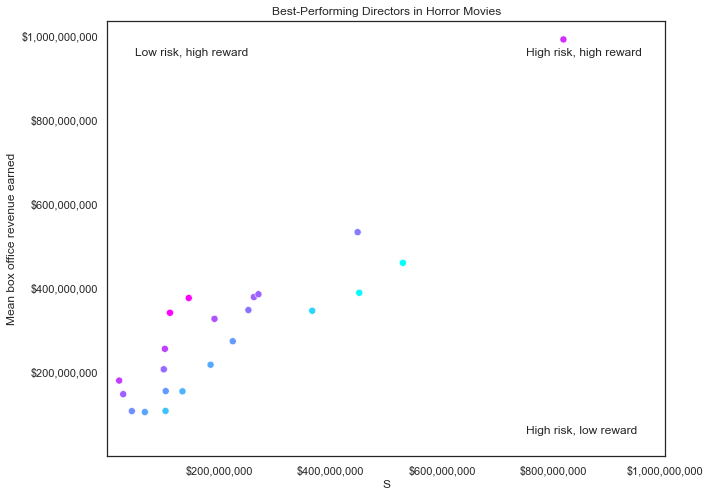

In [32]:
horr_dir_df = generatePeopleVisual(df, 'directors', 'horror')

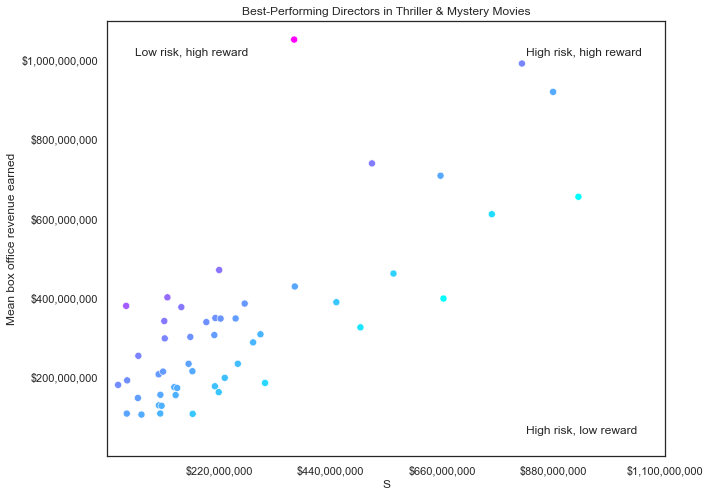

In [33]:
thrl_dir_df = generatePeopleVisual(df, 'directors', ['thriller', 'mystery'])

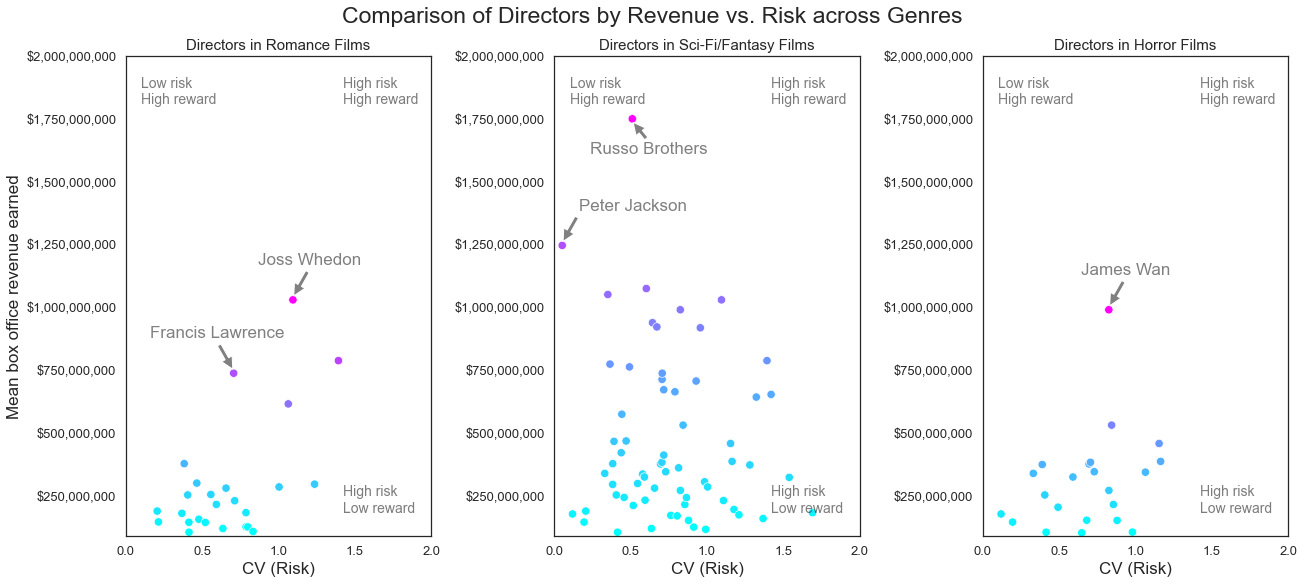

In [34]:
romn_dir_df = generateSpecDF(people_df, 'directors', 'romance')
scif_dir_df = generateSpecDF(people_df, 'directors', ['sci-fi', 'fantasy'])
horr_dir_df = generateSpecDF(people_df, 'directors', 'horror')

# Generates the scatter plot
fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, figsize=(18,8), constrained_layout=True)
   
for df, ax in zip([romn_dir_df, scif_dir_df, horr_dir_df], [ax0, ax1, ax2]):
    sns.scatterplot(x=df.coefficient_of_variation,
                    y=df.mean_total_gross,
                    c=df.mean_total_gross,
                    cmap='cool',
                    marker='o',
                    s=70,
                    ax=ax)
    
    # Miscellaneous formatting
    ax.set_xlim([0,2])
    ax.set_ylim([90000000, 2000000000])
    ax.tick_params(labelsize=13)
    ax.ticklabel_format(style='plain')
    tick = mtick.StrMethodFormatter('${x:,.0f}')
    ax.yaxis.set_major_formatter(tick)
    
    # Labels
    ax.set_xlabel('CV (Risk)', fontsize=17)
    ax.set_ylabel('')
    ax.annotate('Low risk\nHigh reward', xy=(0.05, 0.9), xycoords='axes fraction', alpha=.6, fontsize=14)
    ax.annotate('High risk\nHigh reward', xy=(0.71, 0.9), xycoords='axes fraction', alpha=.6, fontsize=14)  
    ax.annotate('High risk\nLow reward', xy=(0.71, 0.05), xycoords='axes fraction', alpha=.6, fontsize=14)  

# Additional formatting
fig.suptitle('Comparison of Directors by Revenue vs. Risk across Genres', fontsize=23);
ax0.set_ylabel('Mean box office revenue earned', fontsize=17)
ax0.set_title('Directors in Romance Films', fontsize=15)
ax1.set_title('Directors in Sci-Fi/Fantasy Films', fontsize=15)
ax2.set_title('Directors in Horror Films', fontsize=15)

# Annotating directors
# Joss Whedon - Romance
temp_dir = romn_dir_df.sort_values('mean_total_gross', ascending=False).loc[romn_dir_df.primary_name == 'Joss Whedon'].copy()
ax0.annotate('Joss Whedon', 
            xy=(temp_dir.coefficient_of_variation,
                temp_dir.mean_total_gross + 10000000),
            xytext=(temp_dir.coefficient_of_variation + .11,
                temp_dir.mean_total_gross + 140000000),
            arrowprops=dict(facecolor='grey', shrink=0.05),
            color='grey',
            ha='center',
            fontsize=17);

# Francis Lawrence - Romance
temp_dir = romn_dir_df.sort_values('mean_total_gross', ascending=False).loc[romn_dir_df.primary_name == 'Francis Lawrence'].copy()
ax0.annotate('Francis Lawrence', 
            xy=(temp_dir.coefficient_of_variation,
                temp_dir.mean_total_gross + 10000000),
            xytext=(temp_dir.coefficient_of_variation - .11,
                temp_dir.mean_total_gross + 140000000),
            arrowprops=dict(facecolor='grey', shrink=0.05),
            color='grey',
            ha='center',
            fontsize=17);

# Russo Brothers - Sci-Fi/Fantasy
temp_dir = scif_dir_df.sort_values('mean_total_gross', ascending=False).loc[scif_dir_df.primary_name == 'Joe Russo'].copy()
ax1.annotate('Russo Brothers', 
            xy=(temp_dir.coefficient_of_variation,
                temp_dir.mean_total_gross - 10000000),
            xytext=(temp_dir.coefficient_of_variation + .11,
                temp_dir.mean_total_gross - 140000000),
            arrowprops=dict(facecolor='grey', shrink=0.05),
            color='grey',
            ha='center',
            fontsize=17);

# Peter Jackson - Sci-Fi/Fantasy
temp_dir = scif_dir_df.sort_values('mean_total_gross', ascending=False).loc[scif_dir_df.primary_name == 'Peter Jackson'].copy()
ax1.annotate('Peter Jackson', 
            xy=(temp_dir.coefficient_of_variation,
                temp_dir.mean_total_gross + 10000000),
            xytext=(temp_dir.coefficient_of_variation + .11,
                temp_dir.mean_total_gross + 140000000),
            arrowprops=dict(facecolor='grey', shrink=0.05),
            color='grey',
            ha='left',
            fontsize=17);

# James Wan - Horror
temp_dir = horr_dir_df.sort_values('mean_total_gross', ascending=False).loc[horr_dir_df.primary_name == 'James Wan'].copy()
ax2.annotate('James Wan', 
            xy=(temp_dir.coefficient_of_variation,
                temp_dir.mean_total_gross + 10000000),
            xytext=(temp_dir.coefficient_of_variation + .11,
                temp_dir.mean_total_gross + 140000000),
            arrowprops=dict(facecolor='grey', shrink=0.05),
            color='grey',
            ha='center',
            fontsize=17);